# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: NARX

Consider a system generating observations $y_k \in \mathbb{R}$ based on inputs $u_k \in \mathbb{R}$:

$$ y_k = \theta^{\top}\phi(u_k, x_k) + e_k \, ,$$

where $x_k \in \mathbb{R}^{D}$ is a vector of previous observations and $\theta$ are coefficients. The noise instances $e_k$ are assumed to be zero-mean Gaussian distributed with variance $\sigma^2$.

In [44]:
using Revise
using FFTW
using DSP
using ForwardDiff
using Optim
using RxInfer
using LaTeXStrings
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3, margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../NARXsystem.jl"); using .NARXsystem

In [2]:
# Time
N = 100
fs = 20 # Hertz
Δt = 1/fs
tsteps = collect(range(0.0, step=Δt, length=N));

In [3]:
# Define system parameters
sys_mnoise_sd = 1e-2;
input_lims = (-1.,1.)

H = 3
# function sys_basis(x::AbstractVector) 
#     basis = [1.0]
#     for n in 1:length(x)
#         for d in 1:H
#             push!(basis, x[n].^d)
#         end
#     end
#     return basis
# end
# rbf(x, a=0.0, l=1.0) = exp(-(x-a)^2./l)
# sys_basis(x) = cat([1; [rbf(x, a=a) for a in range(-1, stop=1, length=H)]]...,dims=1)
sys_basis(x) = cat([1.0; [x.^d for d in 1:H]]...,dims=1)

M_in = 2
M_out = 2
M = size(sys_basis(zeros(M_out + 1 + M_in)),1);
# sys_coefficients = [0.0; -cos.((1:M-1.)./(π))./2]

df = digitalfilter(Lowpass(1.2; fs=fs), Butterworth(maximum([M_in, M_out])))
sys_coefficients = [0.0; sys_basis([coefb(df)[2:M_out+1]; coefa(df)[1:M_in+1]])[2:end]]

16-element Vector{Float64}:
  0.0
  0.05571953223427204
  0.02785976611713602
  1.0
 -1.475480443592646
  0.5869195080611902
  0.003104666272406081
  0.0007761665681015203
  1.0
  2.1770425394243516
  0.3444745089427895
  0.00017299055244198786
  2.1623819055248483e-5
  1.0
 -3.2121836917899027
  0.20217880932832208

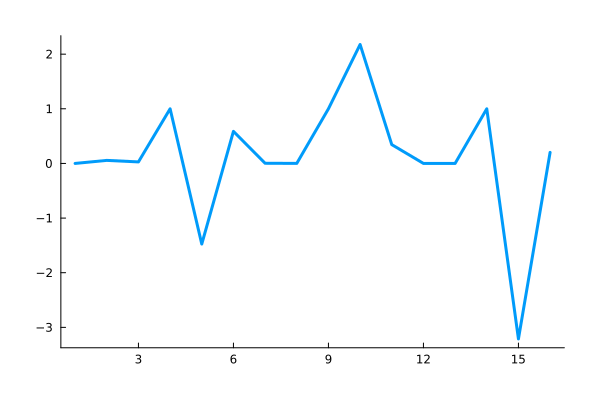

In [4]:
plot(sys_coefficients)

In [5]:
# Specify prior distributions
α0 = 2.0
β0 = 1.0
μ0 = zeros(M)
Λ0 = 1e-2diagm(ones(M))

goal = NormalMeanVariance(0.5, 10.0)

NormalMeanVariance{Float64}(μ=0.5, v=10.0)

## Parameter estimation: random

In [6]:
# Inputs
controls = clamp!(2randn(N).-1, input_lims...)

100-element Vector{Float64}:
  0.5975322268195031
  1.0
  1.0
 -1.0
  0.21673990554681022
  1.0
 -0.5895692168380511
 -0.08325372748239046
 -1.0
  0.17696156520157902
  ⋮
 -0.7674400126235451
 -1.0
 -0.07153437285913311
  0.02100216443411984
 -1.0
 -0.010058078171511164
  0.6170950880937549
 -1.0
  0.03869041266838158

In [7]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

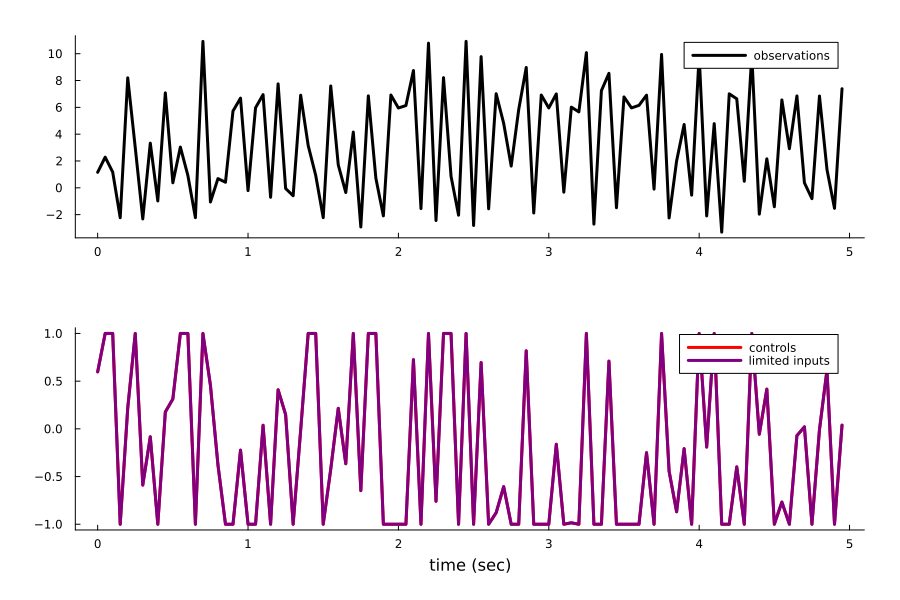

In [8]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [9]:
py_rnd = []
μ_rnd = [μ0]
Λ_rnd = [Λ0]
α_rnd = [α0]
β_rnd = [β0]
FE_rnd = []

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

T = 10
inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_rnd, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    
    push!(μ_rnd, agent.μ )
    push!(Λ_rnd, agent.Λ )
    push!(α_rnd, agent.α )
    push!(β_rnd, agent.β )

    push!(FE_rnd, agent.free_energy)
end

Progress:   2%|▉                                        |  ETA: 0:01:08

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


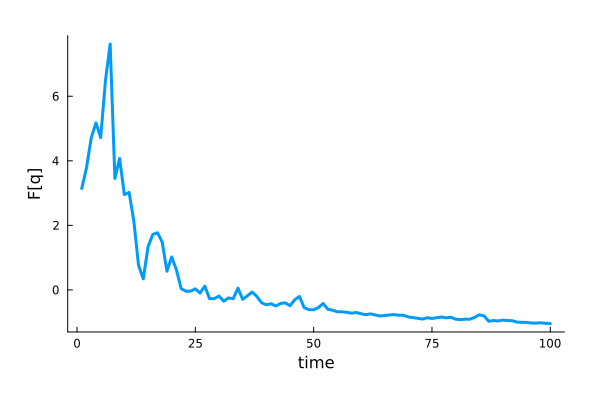

In [10]:
plot(FE_rnd, xlabel="time", ylabel="F[q]")

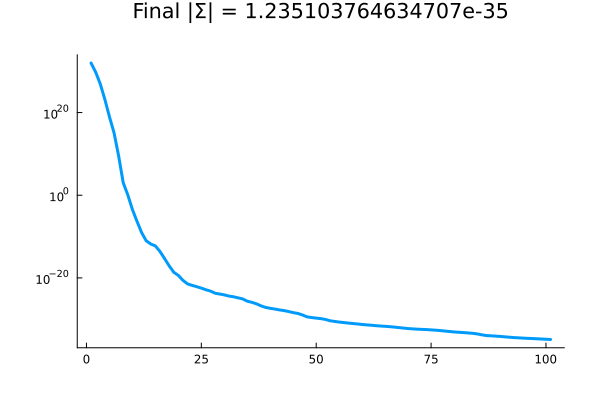

In [11]:
dSθ_rnd = det.(inv.(Λ_rnd))
final_dSθ_rnd = dSθ_rnd[end]
plot(dSθ_rnd, title="Final |Σ| = $final_dSθ_rnd", yscale=:log10)

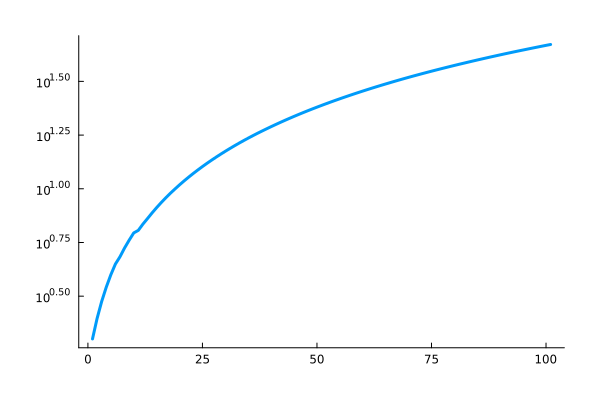

In [12]:
plot(α_rnd ./ β_rnd, yscale=:log10)

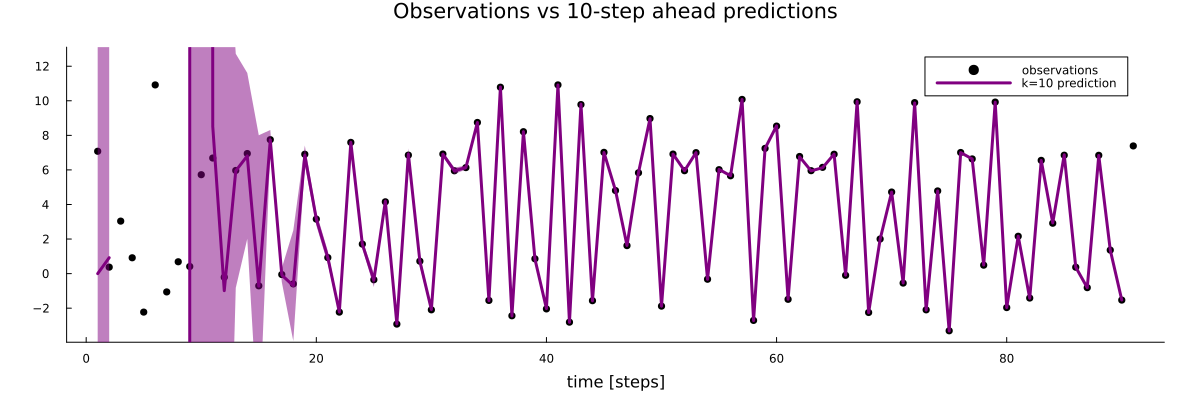

GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA
GKS: Number of points is invalid in routine FILLAREA


In [13]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 10

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end], color="black", label="observations")
plot!([py_rnd[k][1][K] for k in 1:(N-T)], ribbon=[py_rnd[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Parameter estimation: sinusoid control

In [14]:
# Inputs
Ω  = rand(5)*10
controls = mean([sin.(ω.*tsteps) for ω in Ω]);

In [15]:
# Outputs
system = NARXsys(sys_coefficients, sys_basis, sys_mnoise_sd, order_outputs=M_out, order_inputs=M_in, input_lims=input_lims)

outputs = zeros(N)
inputs = zeros(N)
for k in 1:N
    NARXsystem.update!(system, controls[k])
    outputs[k] = system.observation
    inputs[k] = system.input_buffer[1]
end

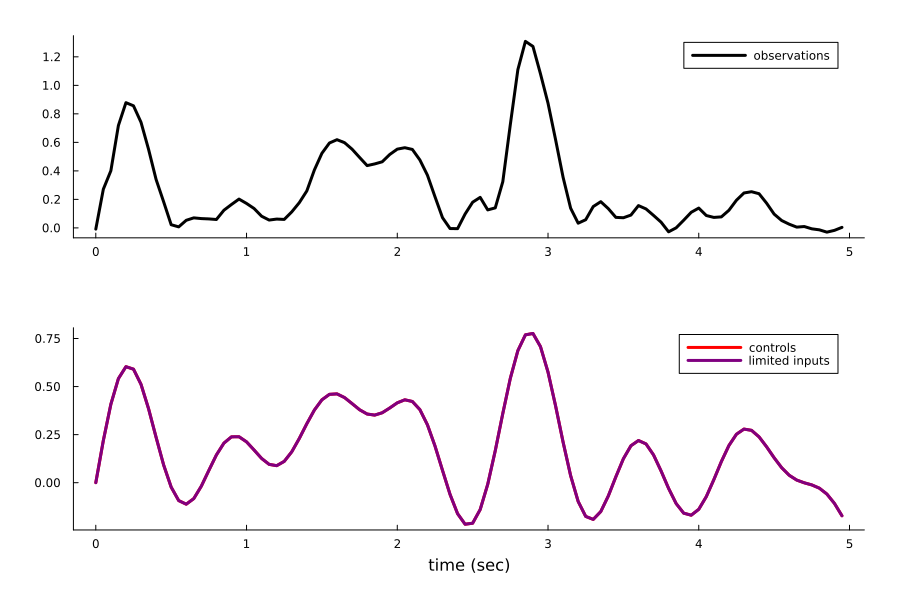

In [16]:
p101 = plot(tsteps, outputs, color="black", label="observations")
p102 = plot(tsteps, controls, color="red", label="controls", xlabel="time (sec)")
plot!(tsteps, inputs, color="purple", label="limited inputs", xlabel="time (sec)")
plot(p101, p102, layout=grid(2,1), size=(900,600))

In [17]:
py_sin = []
μ_sin = [μ0]
Λ_sin = [Λ0]
α_sin = [α0]
β_sin = [β0]
FE_sin = []

agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H)

T = 10
inputs_ = [inputs; zeros(T)]

@showprogress for k in 1:N
    
    # Make predictions
    push!(py_sin, predictions(agent, inputs_[k:k+T], time_horizon=T))
    
    # Update beliefs
    NARXAgents.update!(agent, outputs[k], inputs[k])
    
    push!(μ_sin, agent.μ )
    push!(Λ_sin, agent.Λ )
    push!(α_sin, agent.α )
    push!(β_sin, agent.β )

    push!(FE_sin, agent.free_energy)
end

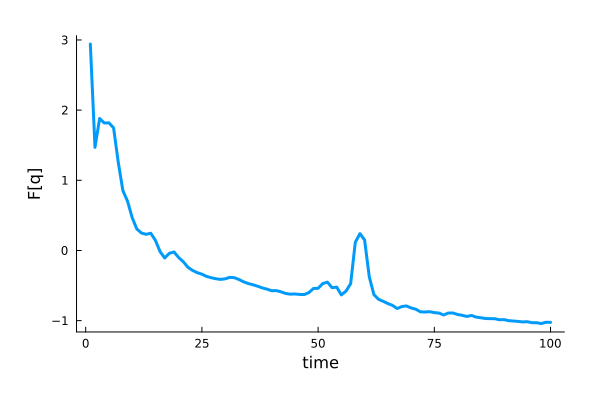

In [18]:
plot(FE_sin, xlabel="time", ylabel="F[q]")

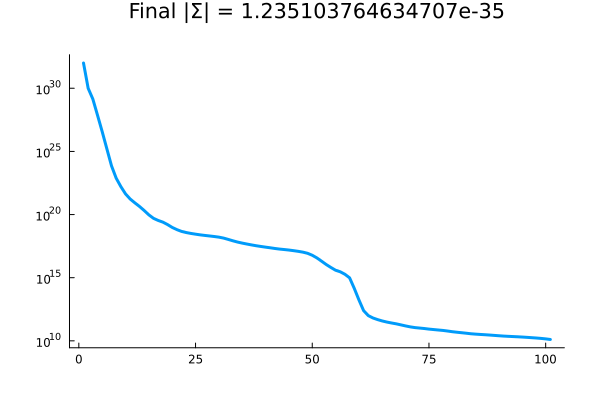

In [19]:
dSθ_sin = det.(inv.(Λ_sin))
final_dSθ_sin = dSθ_sin[end]
plot(dSθ_sin, title="Final |Σ| = $final_dSθ_rnd", yscale=:log10)

In [20]:
# pw = []
# for m in 1:M
#     pwm = plot(ylims=(-1.,1.))
    
#     hline!([sys_coefficients[m]], color="black", label="true")
#     plot!(mθ[m,:], ribbon=sqrt.(vθ[m,:]), color="purple", label="belief", ylabel="θ_$m")
    
#     push!(pw,pwm)
# end
# plot(pw..., layout=(M,1), size=(900,M*300))

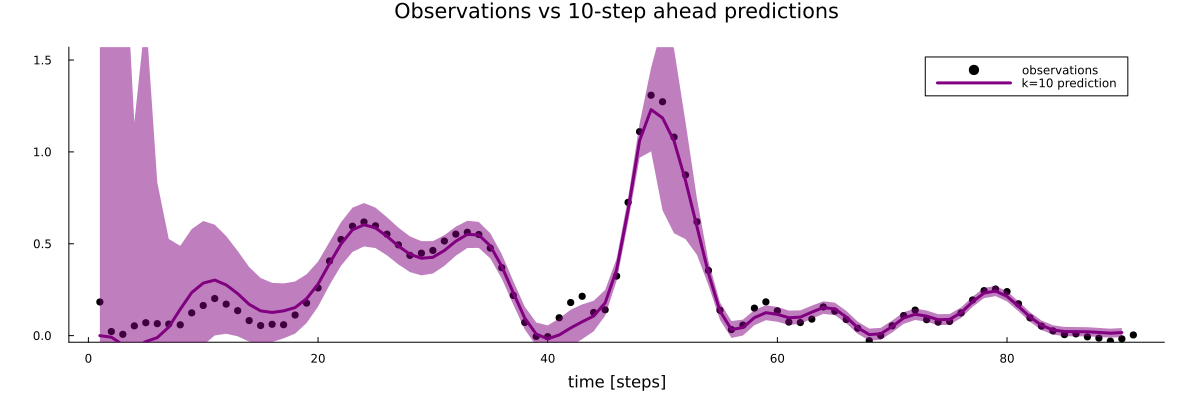

In [21]:
limsb = [minimum(outputs)*1.2, maximum(outputs)*1.2]
K = 10

p1 = plot(xlabel="time [steps]", title="Observations vs $K-step ahead predictions", ylims=limsb, size=(1200,400))
scatter!(outputs[K:end], color="black", label="observations")
plot!([py_sin[k][1][K] for k in 1:(N-T)], ribbon=[py_sin[k][2][K] for k in 1:(N-T)], color="purple", label="k=$K prediction")

## Parameter estimation: EFE

In [22]:
# Time horizon
T = 5

# Solver time limit
tlimit = 10.

10.0

In [23]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

goals = [NormalMeanVariance(mean(goal), 1.0) for t in 1:T]
# gvars = 10 .^range(0, stop=-3, length=N)
# gvars = ones(N)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_EFE = zeros(N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
py_EFE = []
FE_EFE = zeros(N)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = system.observation
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    
    FE_EFE[k] = agent.free_energy
    push!(μ_EFE, agent.μ )
    push!(Λ_EFE, agent.Λ )
    push!(α_EFE, agent.α )
    push!(β_EFE, agent.β )
    
    # Move goal closer
    # goal_k = NormalMeanVariance(mean(goal), gvars[k])
    # update_goals!(goals, goal_k)
    # agent.goals = goals
    
    # Optimal control
    policy = minimizeEFE(agent, goals, time_limit=tlimit, control_lims=input_lims)
    u_EFE[k+1:k+T] = policy

    # Store future predictions
    push!(py_EFE, predictions(agent, policy, time_horizon=T))

    # Act upon environment
    NARXsystem.update!(system, u_EFE[k+1])
    
end

Progress:   2%|▉                                        |  ETA: 0:12:45

Progress:  12%|████▉                                    |  ETA: 0:02:05

Progress:  20%|████████▎                                |  ETA: 0:01:09

Progress:  28%|███████████▌                             |  ETA: 0:00:45

Progress:  36%|██████████████▊                          |  ETA: 0:00:31

Progress:  43%|█████████████████▋                       |  ETA: 0:00:23

Progress:  49%|████████████████████▏                    |  ETA: 0:00:18

Progress:  56%|███████████████████████                  |  ETA: 0:00:14

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:11

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:08

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:06

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:03

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


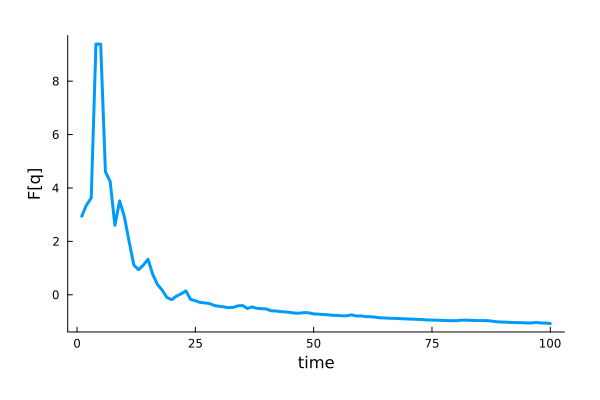

In [24]:
plot(FE_EFE, xlabel="time", ylabel="F[q]")

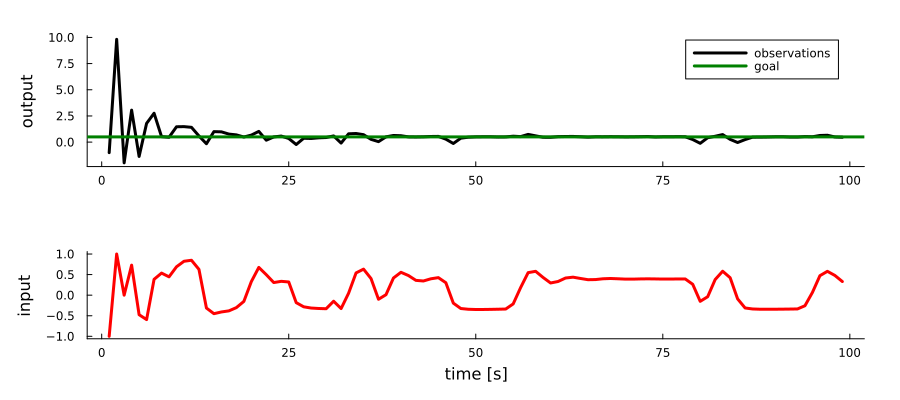

In [78]:
p1 = plot(y_EFE[2:end], color="black", label="observations", ylabel="output")
hline!([mean(goal)], color="green", label="goal")
# vline!([T], color="purple", linestyle=:dash, label="cut")
p4 = plot(u_EFE[2:end-T], color="red", ylabel="input", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.6, .4]), size=(900,400))

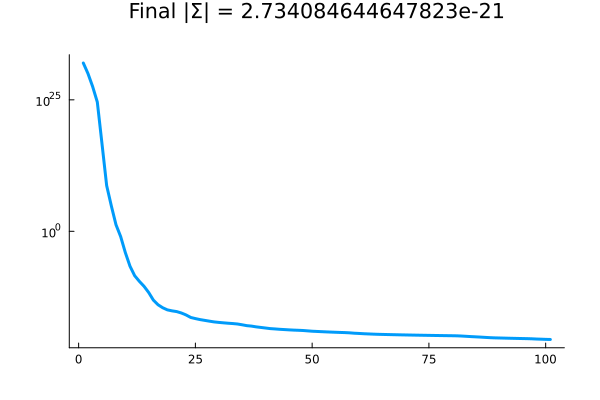

In [26]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-learningrate-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-EFE-learningrate-planning.gif")
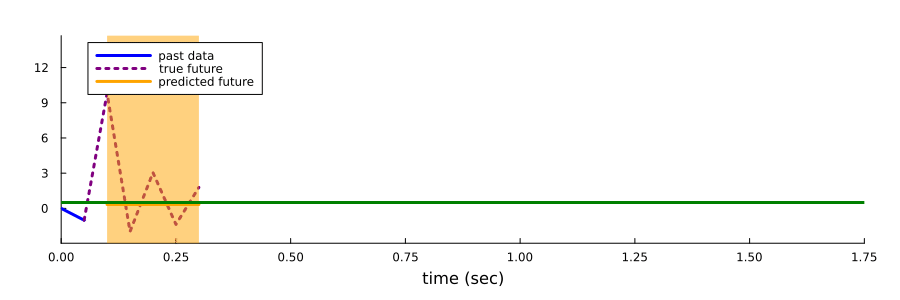

In [27]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_EFE[k][1], ribbon=py_EFE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-learningrate-planning.gif", fps=24)

## Parameter estimation: MSE

In [28]:
# Start system
system = NARXsys(sys_coefficients, 
                 sys_basis,
                 sys_mnoise_sd, 
                 order_outputs=M_out, 
                 order_inputs=M_in)

goals = [NormalMeanVariance(mean(goal), 1.0) for t in 1:T]
# gvars = 10 .^range(0, stop=-3, length=N)
# gvars = ones(N)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goal, 
                  delay_inp=M_in, 
                  delay_out=M_out, 
                  pol_degree=H,
                  time_horizon=T)

# Preallocate
y_MSE = zeros(N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
py_MSE = []
FE_MSE = zeros(N)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = system.observation
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    
    FE_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )
    
    # Optimal control
    policy = minimizeMSE(agent, goals, time_limit=tlimit, control_lims=input_lims)
    u_MSE[k+1:k+T] = policy

    # Store future predictions
    push!(py_MSE, predictions(agent, policy, time_horizon=T))

    # Act upon environment
    NARXsystem.update!(system, u_MSE[k+1])
    
end

Progress:   2%|▉                                        |  ETA: 0:01:35

Progress:  10%|████▏                                    |  ETA: 0:00:19

Progress:  31%|████████████▊                            |  ETA: 0:00:05

Progress:  48%|███████████████████▋                     |  ETA: 0:00:02

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:01

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


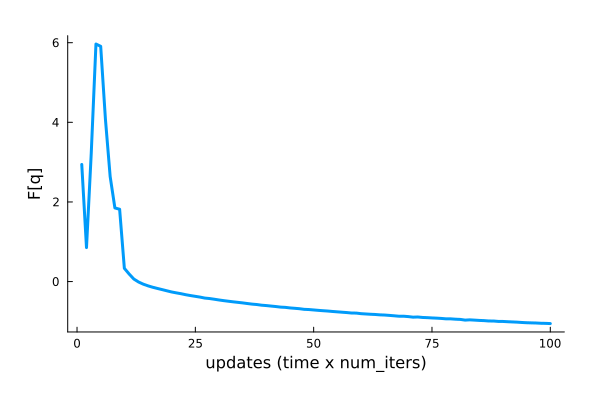

In [29]:
plot(FE_MSE[:], xlabel="updates (time x num_iters)", ylabel="F[q]")

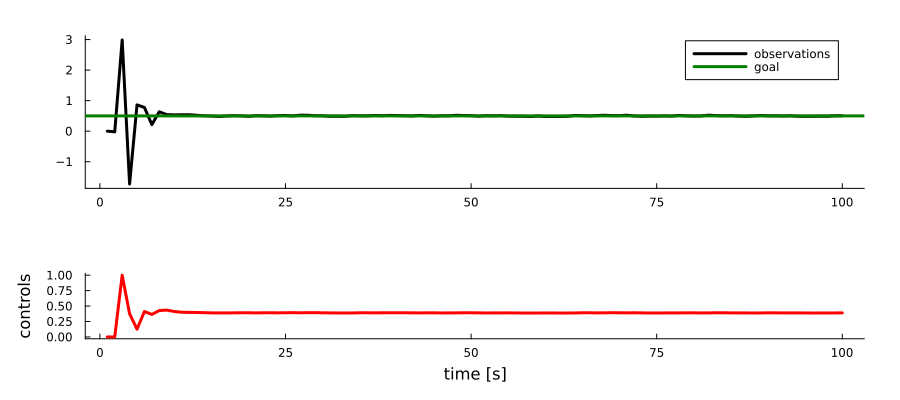

In [30]:
p1 = plot(y_MSE, color="black", label="observations")
hline!([mean(goal)], color="green", label="goal")
p4 = plot(u_MSE[1:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

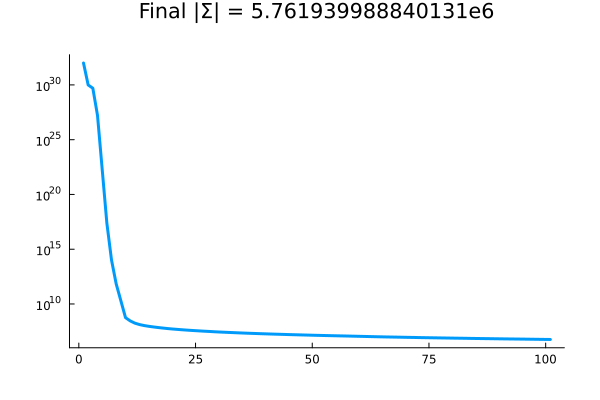

In [31]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-learningrate-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/NARX-MSE-learningrate-planning.gif")
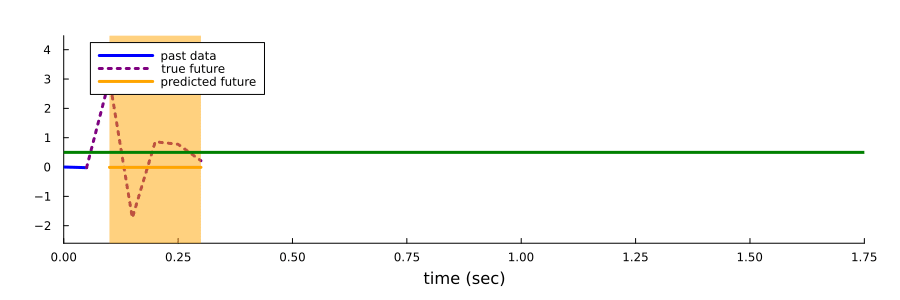

In [32]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]
window = 20

anim = @animate for k in 2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], py_MSE[k][1], ribbon=py_MSE[k][2], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goal)], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-learningrate-planning.gif", fps=24)

### Comparison

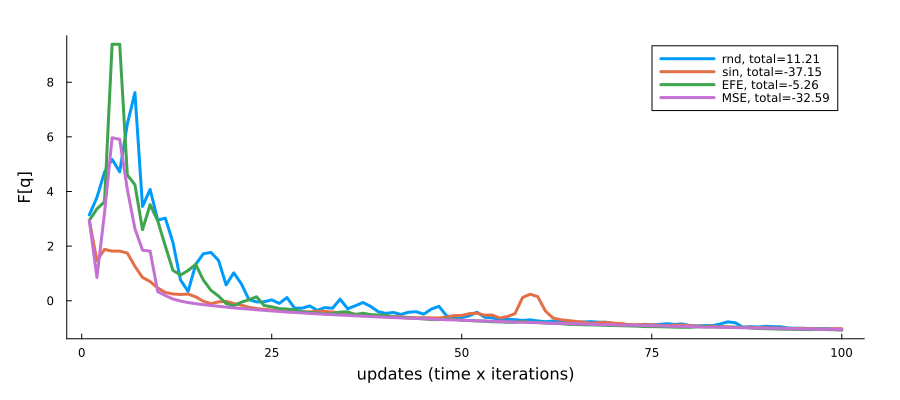

In [33]:
sF_rnd = round(sum(FE_rnd[:]), digits=2)
sF_sin = round(sum(FE_sin[:]), digits=2)
sF_MSE = round(sum(FE_MSE[:]), digits=2)
sF_EFE = round(sum(FE_EFE[:]), digits=2)

plot(xlabel="updates (time x iterations)", ylabel="F[q]", size=(900,400))
plot!(FE_rnd[:], label="rnd, total=$sF_rnd")
plot!(FE_sin[:], label="sin, total=$sF_sin")
plot!(FE_EFE[:], label="EFE, total=$sF_EFE")
plot!(FE_MSE[:], label="MSE, total=$sF_MSE")


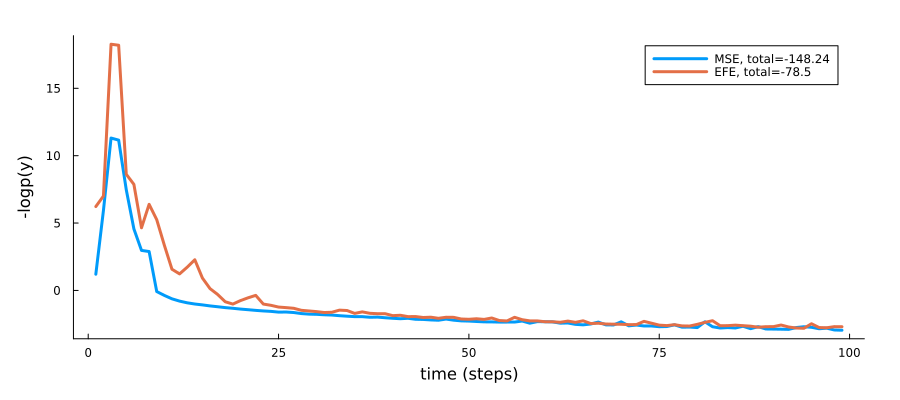

In [34]:
evidence_MSE = [-logpdf(Normal(py_MSE[k][1][1], py_MSE[k][2][1]), y_MSE[k+1]) for k in 1:(N-1)]
evidence_EFE = [-logpdf(Normal(py_EFE[k][1][1], py_EFE[k][2][1]), y_EFE[k+1]) for k in 1:(N-1)]

total_evidence_MSE = round(sum(evidence_MSE), digits=2)
total_evidence_EFE = round(sum(evidence_EFE), digits=2)

plot(xlabel="time (steps)", ylabel="-logp(y)", size=(900,400))
plot!(evidence_MSE, label="MSE, total=$total_evidence_MSE")
plot!(evidence_EFE, label="EFE, total=$total_evidence_EFE")

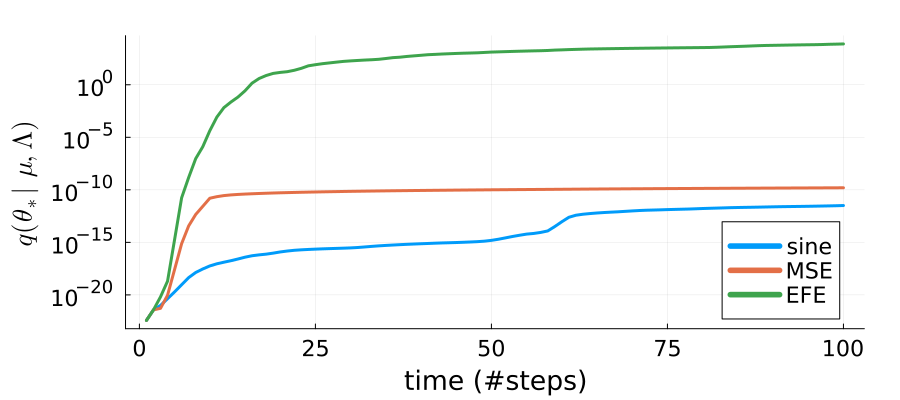

In [76]:
idθ_rnd = [pdf(MvNormalMeanPrecision(μ_rnd[k], Λ_rnd[k]), sys_coefficients) for k in 1:N]
idθ_sin = [pdf(MvNormalMeanPrecision(μ_sin[k], Λ_sin[k]), sys_coefficients) for k in 1:N]
idθ_MSE = [pdf(MvNormalMeanPrecision(μ_MSE[k], Λ_MSE[k]), sys_coefficients) for k in 1:N]
idθ_EFE = [pdf(MvNormalMeanPrecision(μ_EFE[k], Λ_EFE[k]), sys_coefficients) for k in 1:N]

plot(xlabel="time (#steps)", grid=true, guidefontsize=18, tickfontsize=15, legendfontsize=15, yscale=:log10, ylabel=L"$q(θ_{*} \, | \, μ, Λ)$", size=(900,400), legend=:bottomright)
# plot!(idθ_rnd, label="rnd")
plot!(idθ_sin, label="sine")
plot!(idθ_MSE, label="MSE")
plot!(idθ_EFE, label="EFE")

In [77]:
savefig("figures/pθtrue-comparison.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/pθtrue-comparison.png"